In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.metrics import mean_squared_error
from typing import Tuple

lucky_7 = 7

random.seed(lucky_7)
np.random.seed(lucky_7)
warnings.filterwarnings("ignore")

def plot_rg(true: np.array, pred: np.array, title: str) -> None:
    max_ = max(true.max(), pred.max())
    plt.figure(figsize=(5,5))
    plt.plot([0, max_], [0, max_], 'r--')
    sns.scatterplot(true, pred, alpha=0.7)
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

def plot_fi(feature_names: np.array, importances: np.array, title: str) -> None:
    # Addition = 1
    if round(importances.sum()) != 1:
        importances = importances / importances.sum()
        print("sum = ", importances.sum())

    # Combine into a DataFrame for easier sorting and plotting
    feat_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances * 100
    }).sort_values(by='Importance', ascending=False)  # ascending=True puts important features at top

    plt.figure(figsize=(10, len(feature_names) * 0.2))
    ax  = sns.barplot(x='Importance', y='Feature', data=feat_df)

    # Add text labels to the right of each bar
    for i, (value, name) in enumerate(zip(feat_df['Importance'], feat_df['Feature'])):
        ax.text(value + 0.001, i, f"{value:.2f}%", va='center')

    plt.title(f"{title} (Horizontal)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_cm(cm):
    plt.figure(figsize=(2.5,2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def compute_folds(X: np.ndarray, y: np.array, folds: int) -> Tuple[np.ndarray, np.ndarray]:
    if folds > len(X):
        raise ValueError(f"{folds} > {len(X)} IMPOSSIBLE")
    
    X_folds = np.array_split(X, folds)
    y_folds = np.array_split(y, folds)

    print(f"Number of folds: {folds}")
    return X_folds, y_folds

def cross_validation(model_class: object, X: np.ndarray, y: np.array, folds: int) -> None:
    X_folds, y_folds = compute_folds(X, y, folds)
    acc_scores = []

    for i in range(folds):
        # Create training data by excluding fold i
        X_train = np.vstack(X_folds[:i] + X_folds[i+1:])
        y_train = np.hstack(y_folds[:i] + y_folds[i+1:])

        # Validation data = fold i
        X_val = X_folds[i]
        y_val = y_folds[i]

        # Reinitialize model to avoid accumulation across folds
        model = model_class()

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = mean_squared_error(y_val, y_pred)
        acc_scores.append(acc)
        print(f"Fold {i} rmse: {acc:.4f}")

    print(f"\nAverage rmse: {np.mean(acc_scores):.4f}")

### Load the datasets

In [8]:
shhs1_dataset_df = pd.read_csv("shhs1-dataset-0.21.0.csv")
odi_df = pd.read_csv("data/shhs/polysomnography/edfs/shhs1/extracted_122_features.csv")

In [9]:
shhs1_dataset_df = shhs1_dataset_df.set_index("nsrrid")
shhs1_dataset_df.head()

,pptid,ecgdate,lvh3_1,lvh3_3,st4_1_3,st5_1_3,lvhst,mob1,part2deg,mob2,...,eoglqual,chinqual,oximqual,posqual,lightoff,oximet51,monitor_id,headbox_id,rcrdtime,psg_month
nsrrid,,,,,,,,,,,,,,,,,,,,,
200001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,96.0,18.0,18.0,7:16:00,6
200002,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,4,4,NaN,94.0,17.0,17.0,9:00:00,1
200003,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,95.0,17.0,17.0,7:10:00,2
200004,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,3,3,0.0,96.0,19.0,19.0,5:58:00,4
200005,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,0.0,96.0,18.0,18.0,7:57:00,3


In [10]:
odi_df.head()

,nsrrid,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,DD100_sd_thr3,...,PRSAc_win20,PRSAad_win20,PRSAos_win20,PRSAsb_win20,PRSAsa_win20,AC_win20,PSD_total,PSD_band,PSD_ratio,PSD_peak
0,200010,1.7142857142857142,29.16666666666667,15.534012860673046,143.95833333333334,68.66660345870878,49.125,32.61909269635397,6.666666666666668,0.8498365855987975,...,-0.3978468113083444,1.0039447731755469,-0.008349507766810524,0.011531788050006377,0.029975950724934964,205928.6260241745,0.003211213689559329,0.0011244131983455536,0.3501520942070521,0.00029953237501114635
1,200008,2.4285714285714293,24.52941176470589,12.971088425729619,127.88235294117644,67.77895070867909,35.117647058823536,15.138118435188222,7.588235294117648,1.2860712417103204,...,-0.35086277732128224,1.4428923582580069,-0.02558932940318464,0.016933665305415613,0.0010719073773149985,202230.1152273766,0.004472742439521433,0.0014242953258712234,0.3184389320713084,0.0005002519817708592
2,200004,1.2857142857142858,46.77777777777778,23.606862362823314,285.4444444444445,164.82321243691584,110.11111111111113,93.1467712143278,7.8888888888888875,0.9938079899999066,...,-0.3694620253164551,1.0126582278480925,-0.008772432928808027,0.011806890644329757,0.017424891342276958,202916.41884963238,0.004051458099403181,0.0009218562083553672,0.2275368980099204,0.00032587925427432404
3,200006,3.571428571428571,40.48,20.35705283188114,254.28,121.17145538450876,93.16,63.30730131667279,8.64,1.2924395537122808,...,-0.369187553387988,0.9834926151172853,-0.014594057361714066,-0.0010515770623038745,0.025234753465151208,198543.37034046766,0.007086822878527224,0.002097640711519338,0.2959916943705622,0.0009043723877737494
4,200007,6.7142857142857135,36.97872340425532,16.445253291363798,197.6170212765957,94.16843288931452,83.23404255319149,53.91343051634485,7.127659574468084,1.2819038579908142,...,-0.40547160102109103,1.0609283711147557,-0.021627269779469167,-0.01099149632670491,0.02696396182629126,204047.1481791494,0.010954513077902843,0.003898348712296114,0.35586690933436005,0.0017107508973740893


In [11]:
odi_df = odi_df.set_index(odi_df.columns[0])
odi_df.head()

,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,DD100_sd_thr3,DDmax_u_thr3,...,PRSAc_win20,PRSAad_win20,PRSAos_win20,PRSAsb_win20,PRSAsa_win20,AC_win20,PSD_total,PSD_band,PSD_ratio,PSD_peak
nsrrid,,,,,,,,,,,,,,,,,,,,,
200010,1.7142857142857142,29.16666666666667,15.534012860673046,143.95833333333334,68.66660345870878,49.125,32.61909269635397,6.666666666666668,0.8498365855987975,3.4166666666666665,...,-0.3978468113083444,1.0039447731755469,-0.008349507766810524,0.011531788050006377,0.029975950724934964,205928.6260241745,0.003211213689559329,0.0011244131983455536,0.3501520942070521,0.00029953237501114635
200008,2.4285714285714293,24.52941176470589,12.971088425729619,127.88235294117644,67.77895070867909,35.117647058823536,15.138118435188222,7.588235294117648,1.2860712417103204,3.647058823529412,...,-0.35086277732128224,1.4428923582580069,-0.02558932940318464,0.016933665305415613,0.0010719073773149985,202230.1152273766,0.004472742439521433,0.0014242953258712234,0.3184389320713084,0.0005002519817708592
200004,1.2857142857142858,46.77777777777778,23.606862362823314,285.4444444444445,164.82321243691584,110.11111111111113,93.1467712143278,7.8888888888888875,0.9938079899999066,4.111111111111111,...,-0.3694620253164551,1.0126582278480925,-0.008772432928808027,0.011806890644329757,0.017424891342276958,202916.41884963238,0.004051458099403181,0.0009218562083553672,0.2275368980099204,0.00032587925427432404
200006,3.571428571428571,40.48,20.35705283188114,254.28,121.17145538450876,93.16,63.30730131667279,8.64,1.2924395537122808,4.48,...,-0.369187553387988,0.9834926151172853,-0.014594057361714066,-0.0010515770623038745,0.025234753465151208,198543.37034046766,0.007086822878527224,0.002097640711519338,0.2959916943705622,0.0009043723877737494
200007,6.7142857142857135,36.97872340425532,16.445253291363798,197.6170212765957,94.16843288931452,83.23404255319149,53.91343051634485,7.127659574468084,1.2819038579908142,4.0212765957446805,...,-0.40547160102109103,1.0609283711147557,-0.021627269779469167,-0.01099149632670491,0.02696396182629126,204047.1481791494,0.010954513077902843,0.003898348712296114,0.35586690933436005,0.0017107508973740893


In [12]:
odi_df.index

Int64Index([200010, 200008, 200004, 200006, 200007, 200003, 200005, 200001,
            200011, 200017,
            ...
            200192, 200197, 200201, 200200, 200193, 200183, 200189, 200202,
            200203, 200199],
           dtype='int64', name='nsrrid', length=194)

### Inner join for datasets based on `nsrr_id`

In [6]:
df = shhs1_dataset_df.merge(right=odi_df, how="inner", left_index=True, right_index=True).loc[:, ["age_s1", "gender", "ahi_o0h3"] + odi_df.columns.tolist()]

In [7]:
print(shhs1_dataset_df.shape[0], odi_df.shape[0], df.shape[0])

5804 142 142


In [8]:
df.head()

,age_s1,gender,ahi_o0h3,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,...,PRSAc,PRSAad,PRSAos,PRSAsb,PRSAsa,AC,PSD_total,PSD_band,PSD_ratio,PSD_peak
200001,55,1,4.314248,3.142857,40.318182,22.475009,323.659091,203.137962,90.068182,84.195699,...,-0.338299,0.986975,-0.028169,0.016069,0.024809,103438.680219,0.006747,0.002047,0.303393,0.000652
200002,78,1,31.318681,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,...,-0.451494,1.689968,-0.106708,-0.055897,-0.042257,105522.715545,0.026928,0.012601,0.467954,0.004824
200003,77,2,8.870293,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,...,-0.424613,1.009535,-0.053831,0.004544,0.021189,109267.875581,0.008494,0.003076,0.362082,0.000906
200004,48,1,2.990033,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,...,-0.369462,1.012658,-0.029063,0.018169,0.032183,110650.182464,0.004051,0.000922,0.227537,0.000326
200005,66,2,6.000000,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,...,-0.404726,1.006707,-0.044592,0.005684,0.030181,107762.356450,0.007806,0.002634,0.337397,0.000802


### Choose of Target Variable

#### 1. `ahi_o0h3`

* Counts **obstructive apneas** with **no oxygen desaturation threshold**, with or without arousal.
* Counts **hypopneas** that have both:

  * \> 30% flow reduction for mare than $n$ $seconds$ (say $10s$)
  * **AND** ≥3% oxygen desaturation
  * With or without arousal.
* The formula:

  $\text{AHI} = \frac{\text{(n obstructive apneas) + (n hypopneas meeting criteria)}}{\text{hours of sleep}}$

#### 2. `ahi_o0h3a`

* Counts **obstructive apneas** same as above.
* Counts **hypopneas** that have:

  * \> 30% flow reduction for mare than $n$ $seconds$ (say $10s$)
  * **AND** either:

    * ≥3% oxygen desaturation **OR**
    * Presence of arousal
* So this is a bit broader in the hypopnea count because it includes events with desaturation **or** arousal (not necessarily both).

`≥3% oxygen desaturation`: this means the blood oxygen saturation (SpO₂) level drops by 3% or more from the baseline during a breathing event (like hypopnea or apnea).

`> 30% flow reduction`: It refers to a partial blockage of the airway, leading to a reduction in airflow (but not a complete stop like in apnea). Specifically: the person’s breathing is reduced by at least 30% of normal baseline airflow. This is measured using nasal pressure sensors or thermal airflow sensors in polysomnography (PSG).

`Arousal`: An arousal is a brief awakening or change in brain activity during sleep, detected by EEG.

#### Key difference:

* `ahi_o0h3`: Hypopneas require **both ≥3% desaturation AND with/without arousal**.
* `ahi_o0h3a`: Hypopneas require **≥3% desaturation OR arousal** (more inclusive).

#### What does this mean for your model?

* Since you’re working with only **SpO₂ (oxygen saturation) signals**, you can detect events related to **desaturation** but **not arousals** (which require EEG).
* So **`ahi_o0h3` aligns better** with your data, since it strictly requires ≥3% desaturation in hypopneas.
* Using **`ahi_o0h3a` might overestimate hypopneas** in your dataset because it counts events with arousal but no desaturation, which you can’t detect with SpO₂ alone.

#### Summary for your use case:

| AHI Variable | Includes hypopneas with desaturation only? | Includes hypopneas with arousal only? | Suitable for SpO₂-only models? |
| ------------ | ------------------------------------------ | ------------------------------------- | ------------------------------ |
|**`ahi_o0h3`**| **Yes**                                    | **No**                                | **Yes**                        |
| `ahi_o0h3a`  | Yes                                        | Yes                                   | No                             |


So, Based on the above logic let's choose `ahi_o0h3`

In [9]:
X = df.drop(columns=["ahi_o0h3"])
y = df["ahi_o0h3"]

In [10]:
X.head()

,age_s1,gender,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,...,PRSAc,PRSAad,PRSAos,PRSAsb,PRSAsa,AC,PSD_total,PSD_band,PSD_ratio,PSD_peak
200001,55,1,3.142857,40.318182,22.475009,323.659091,203.137962,90.068182,84.195699,9.363636,...,-0.338299,0.986975,-0.028169,0.016069,0.024809,103438.680219,0.006747,0.002047,0.303393,0.000652
200002,78,1,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,9.437500,...,-0.451494,1.689968,-0.106708,-0.055897,-0.042257,105522.715545,0.026928,0.012601,0.467954,0.004824
200003,77,2,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,8.088235,...,-0.424613,1.009535,-0.053831,0.004544,0.021189,109267.875581,0.008494,0.003076,0.362082,0.000906
200004,48,1,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,...,-0.369462,1.012658,-0.029063,0.018169,0.032183,110650.182464,0.004051,0.000922,0.227537,0.000326
200005,66,2,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,8.350000,...,-0.404726,1.006707,-0.044592,0.005684,0.030181,107762.356450,0.007806,0.002634,0.337397,0.000802


In [11]:
y.head()

200001     4.314248
200002    31.318681
200003     8.870293
200004     2.990033
200005     6.000000
Name: ahi_o0h3, dtype: float64

### Distribution of the target variable

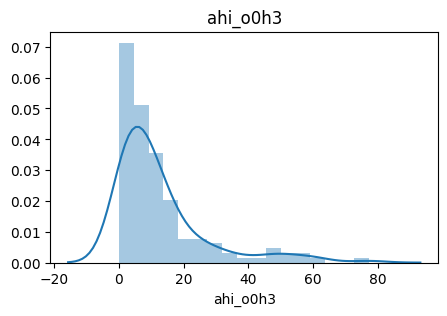

In [12]:
plt.figure(figsize=(5, 3))
sns.distplot(y, kde=True)
plt.grid(False)
plt.title("ahi_o0h3")
plt.show(block=False)

### Plot each feature distributions

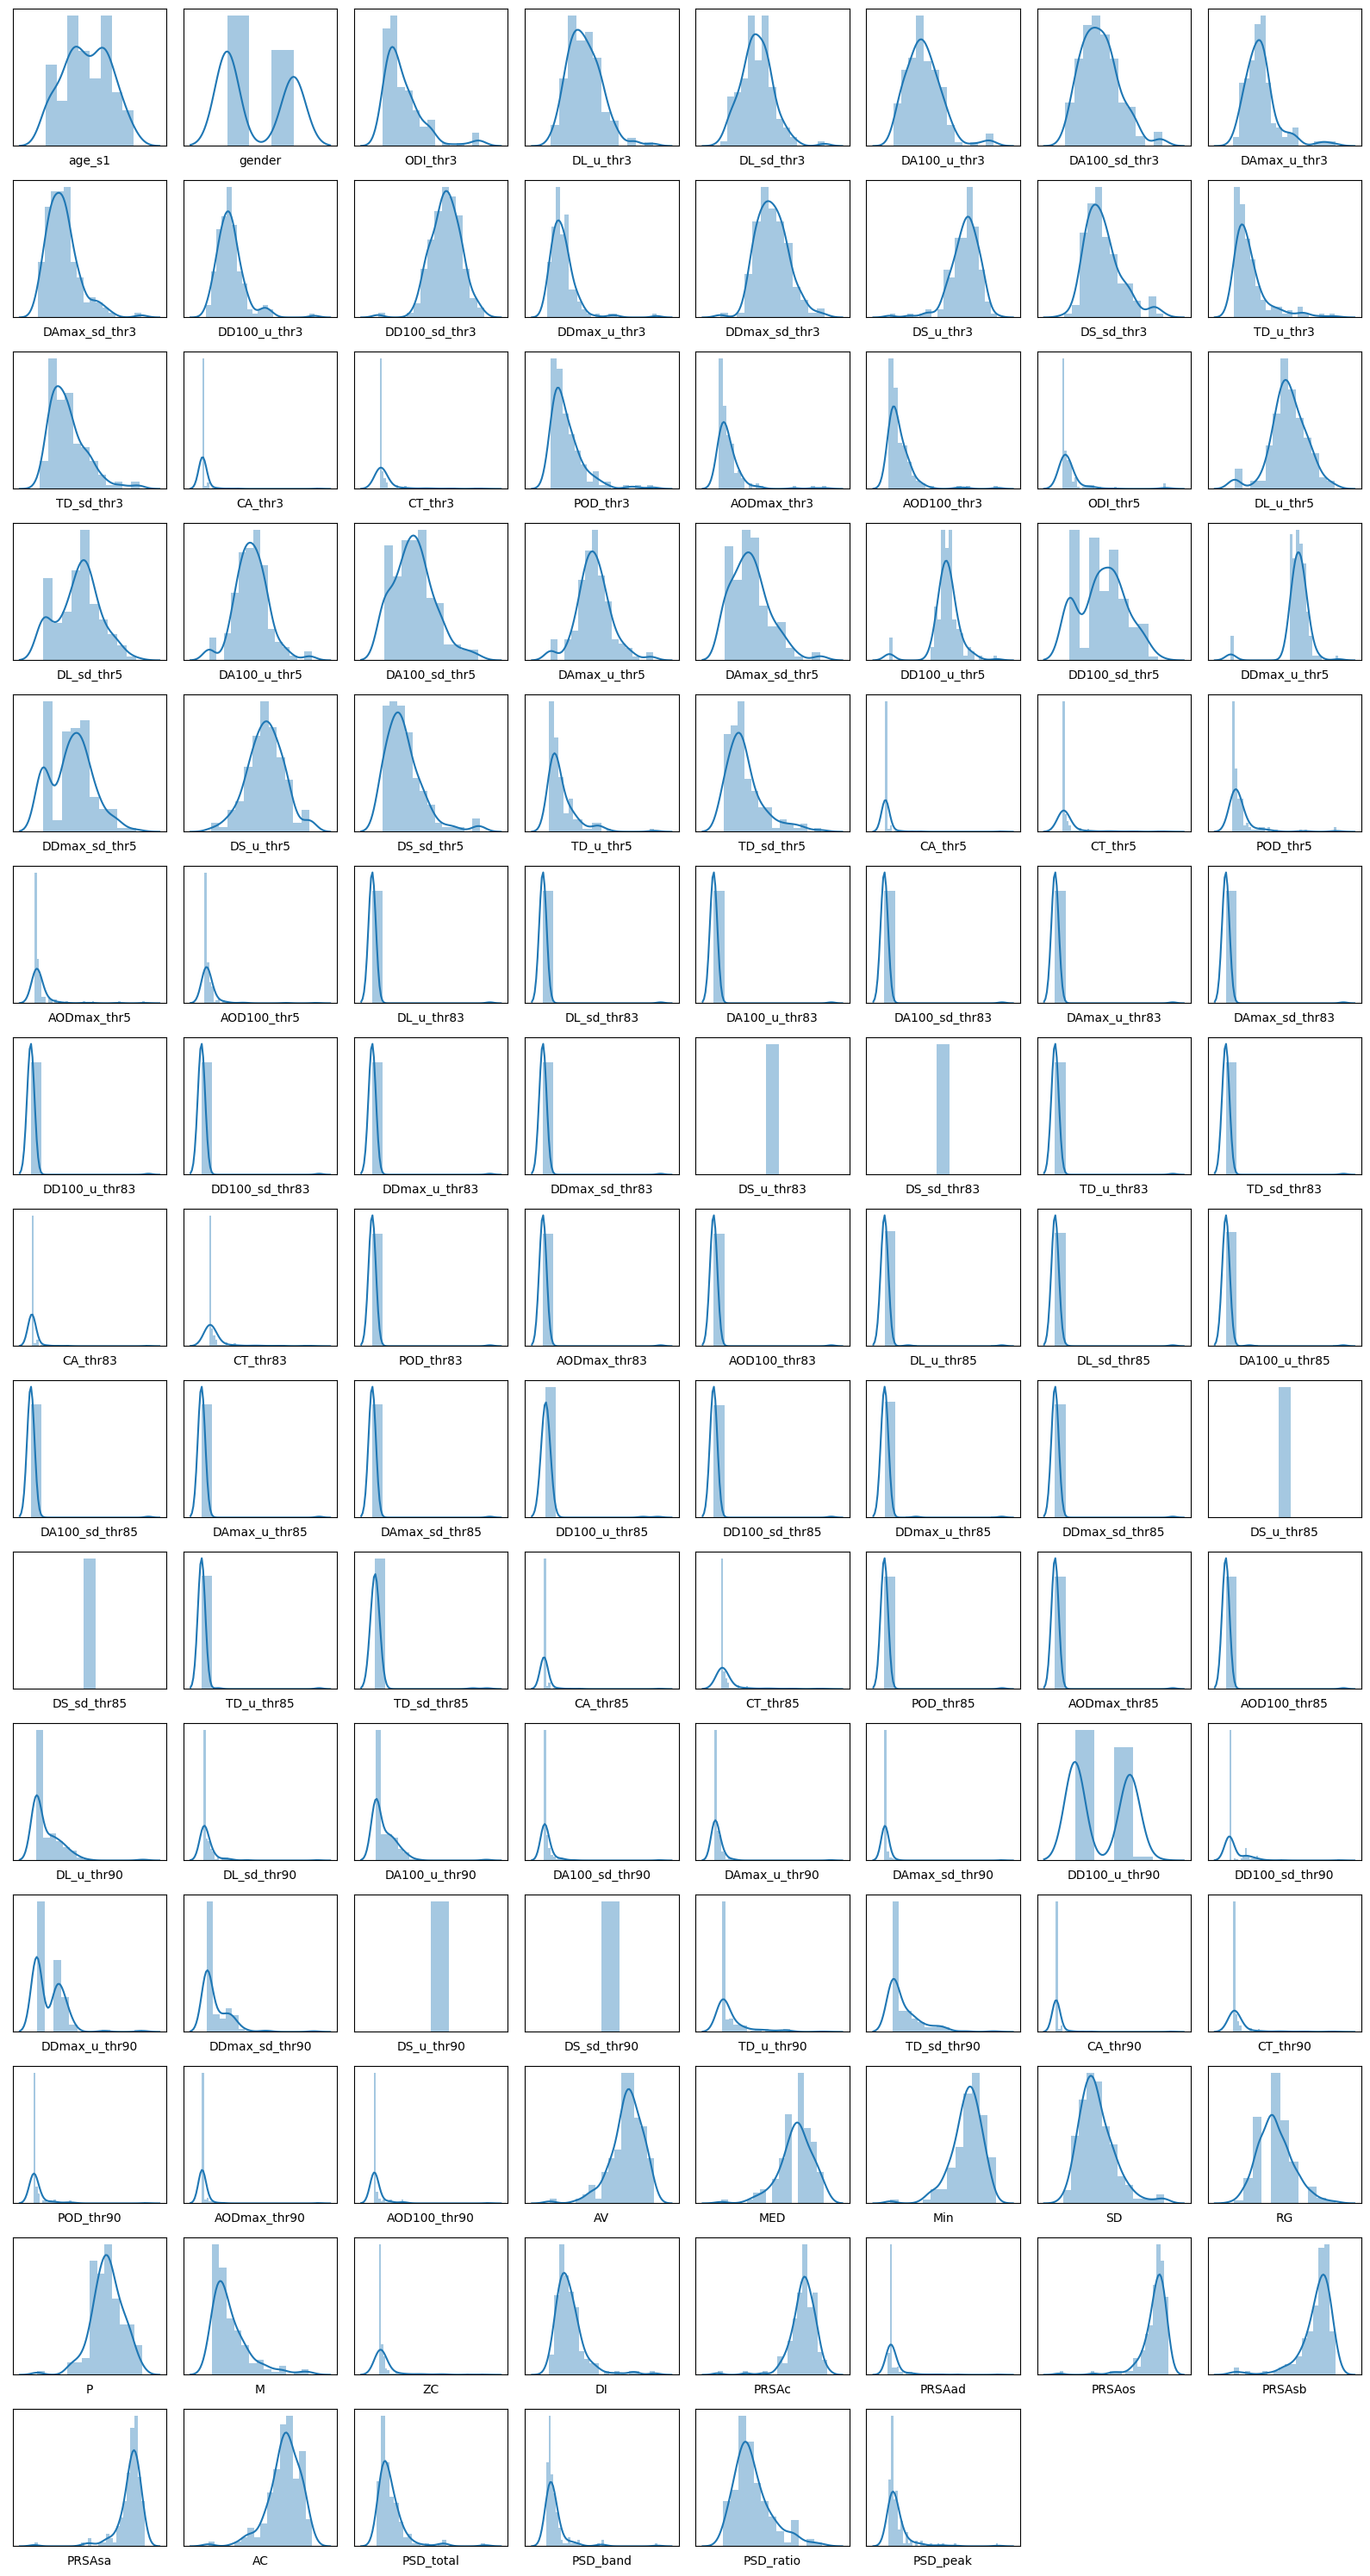

In [ ]:
n_features = X.shape[1]
n_cols = 8
n_rows = (n_features // n_cols) + (1 if n_features % n_cols else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2), squeeze=False)

for i, col in enumerate(X.columns):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.distplot(X[col], kde=True, ax=ax)
    ax.tick_params(axis='both', which='both', labelsize=5)
    # Optionally hide x/y labels to save space:
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused subplots if any
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

### Train test split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(113, 118) (113,) (29, 118) (29,)


In [15]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

### Apply scaler

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, y_train.shape, X_train_scaled.shape, y_test.shape)

(113, 118) (113,) (113, 118) (29,)


### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

log_model = LinearRegression()
log_model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
from sklearn.metrics import mean_squared_error

y_pred = log_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))


373.5469713432994


In [19]:
cross_validation(LinearRegression, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 53.3158
Fold 1 rmse: 109.4947
Fold 2 rmse: 12233.5122
Fold 3 rmse: 298.3285
Fold 4 rmse: 91.6843
Fold 5 rmse: 27.2472
Fold 6 rmse: 71.4248
Fold 7 rmse: 240.7695
Fold 8 rmse: 60.3349
Fold 9 rmse: 2343.5065

Average rmse: 1552.9618


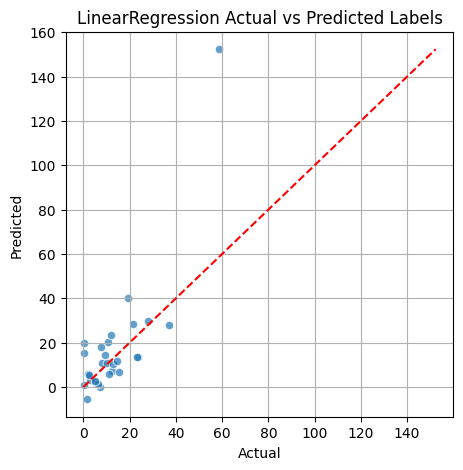

In [20]:
plot_rg(y_test, y_pred, title="LinearRegression Actual vs Predicted Labels")

sum =  0.9999999999999997


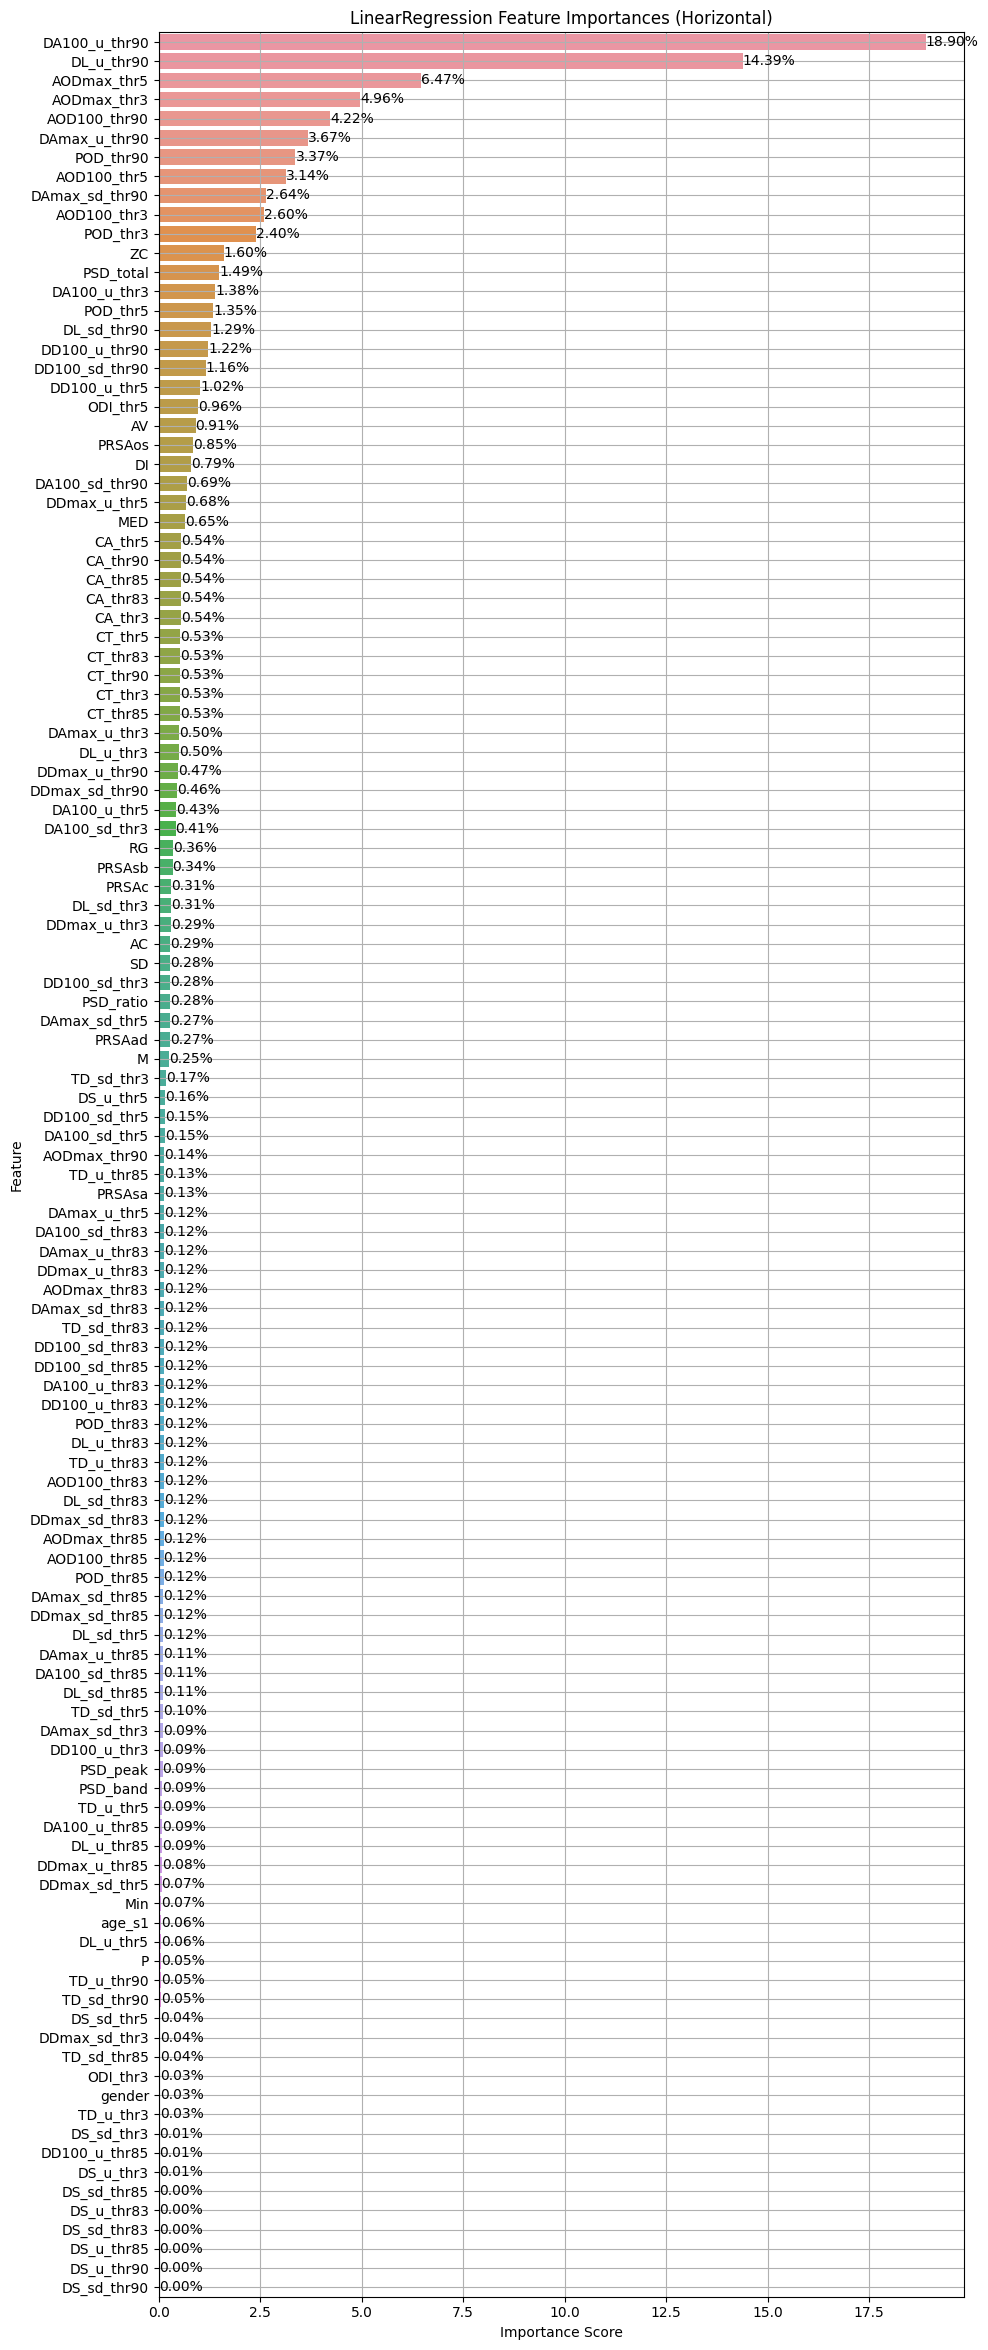

In [21]:
# Get feature importances and names
importances = abs(log_model.coef_)
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="LinearRegression Feature Importances")

### Decision Tree Regression

In [22]:
from sklearn.tree import DecisionTreeRegressor

dtree_model = DecisionTreeRegressor()
dtree_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [23]:
y_pred = dtree_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

73.11580524208574


In [24]:
cross_validation(DecisionTreeRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 42.7154
Fold 1 rmse: 88.7051
Fold 2 rmse: 90.0160
Fold 3 rmse: 85.7204
Fold 4 rmse: 139.0630
Fold 5 rmse: 15.6496
Fold 6 rmse: 65.3396
Fold 7 rmse: 202.1291
Fold 8 rmse: 90.7530
Fold 9 rmse: 235.6759

Average rmse: 105.5767


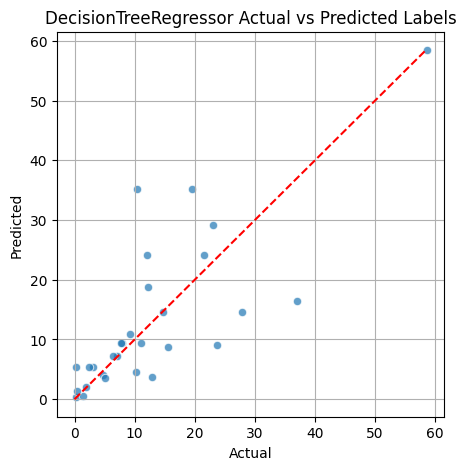

In [25]:
plot_rg(y_test, y_pred, title="DecisionTreeRegressor Actual vs Predicted Labels")

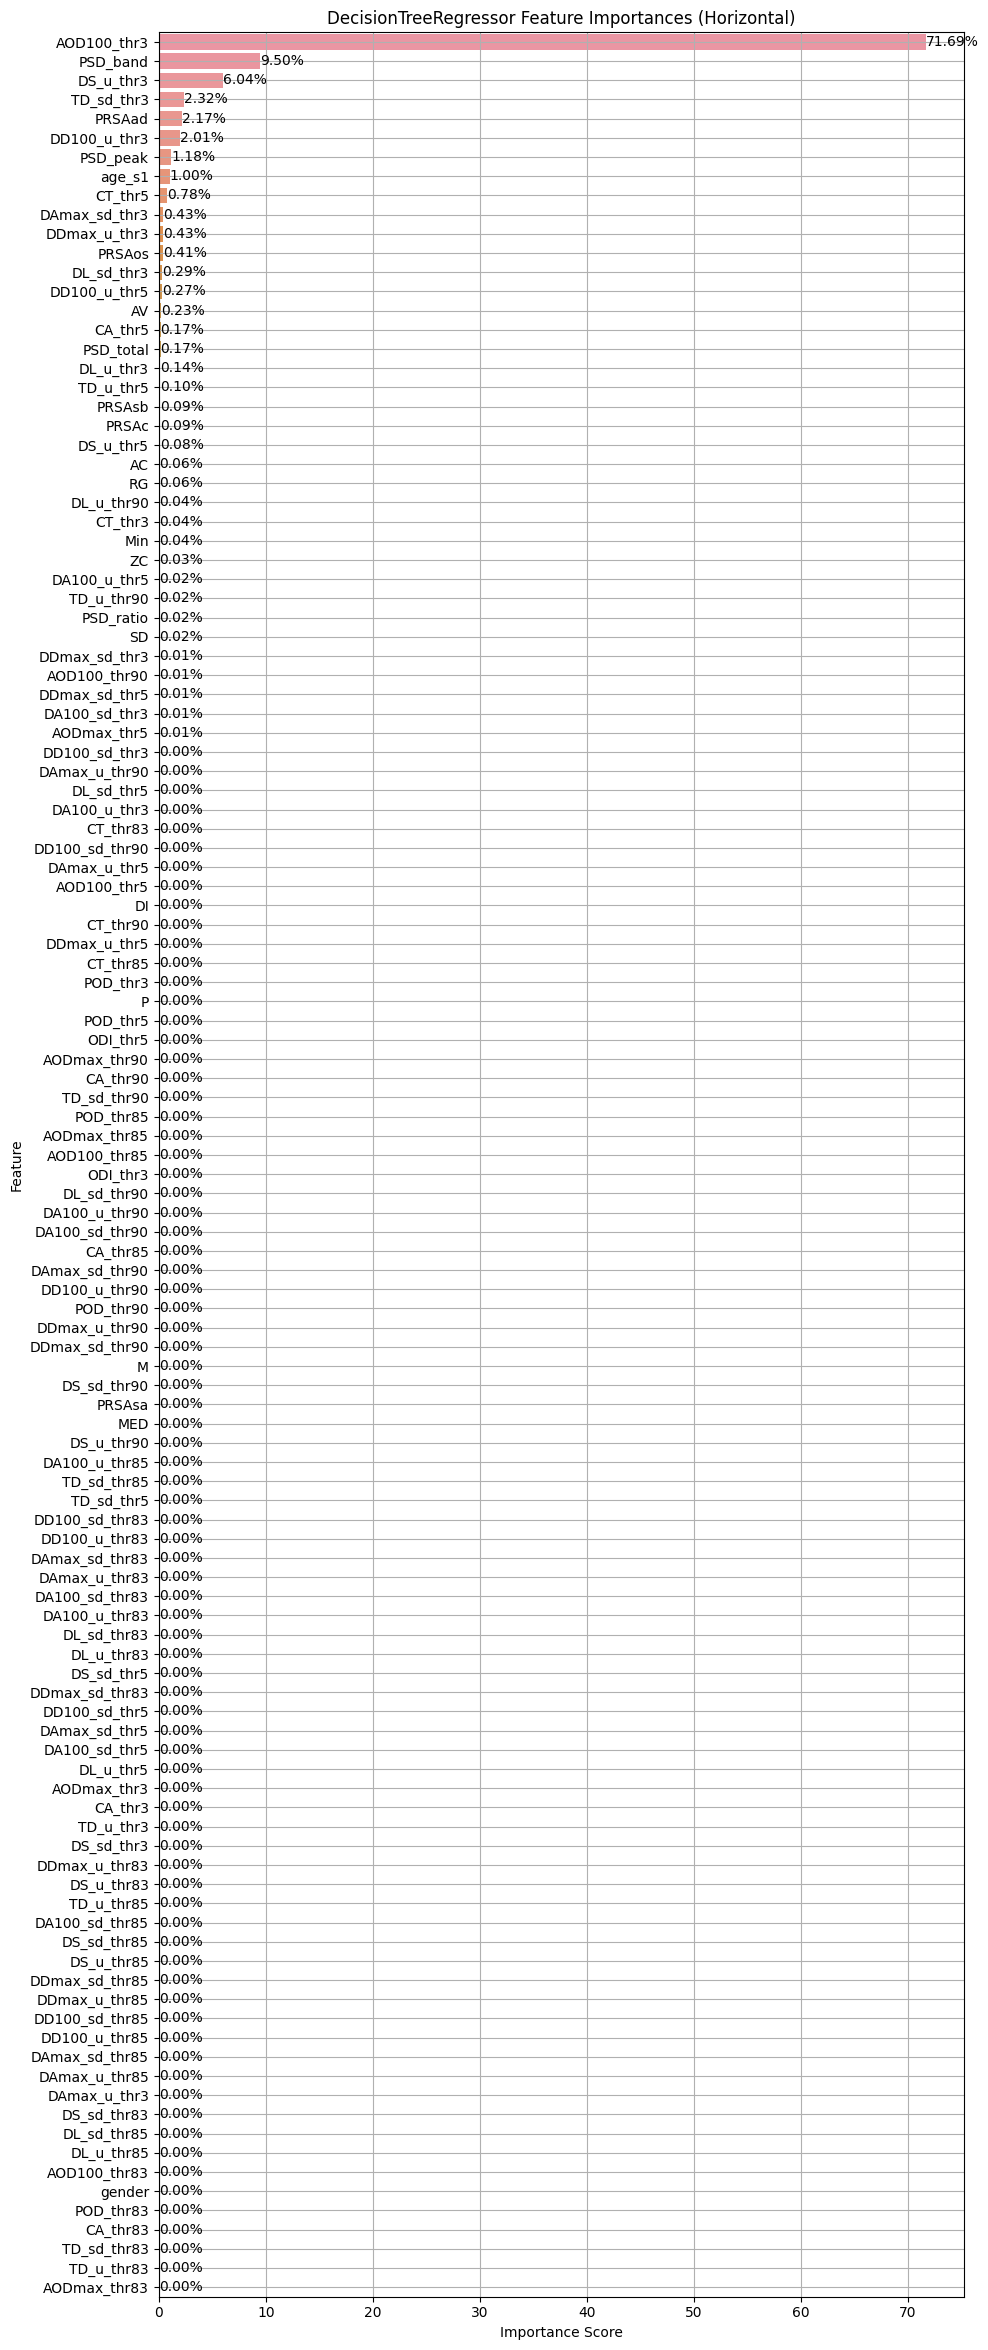

In [26]:
# Get feature importances and names
importances = dtree_model.feature_importances_
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="DecisionTreeRegressor Feature Importances")

### XBG Regression

In [27]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror', ...)

In [28]:
y_pred = xgb_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

51.21274030330073


In [29]:
cross_validation(XGBRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 52.5886
Fold 1 rmse: 55.2350
Fold 2 rmse: 58.4654
Fold 3 rmse: 82.4169
Fold 4 rmse: 52.9738
Fold 5 rmse: 25.0753
Fold 6 rmse: 36.6082
Fold 7 rmse: 35.9039
Fold 8 rmse: 22.2785
Fold 9 rmse: 60.0476

Average rmse: 48.1593


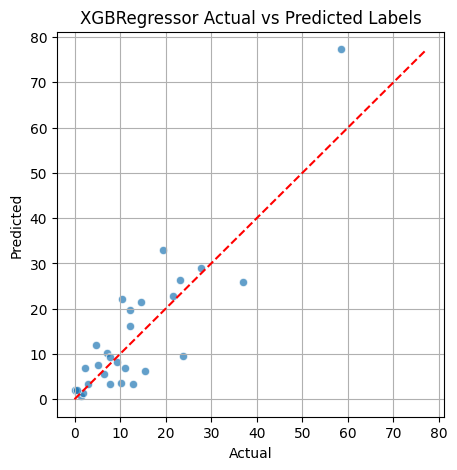

In [30]:
plot_rg(y_test, y_pred, title="XGBRegressor Actual vs Predicted Labels")

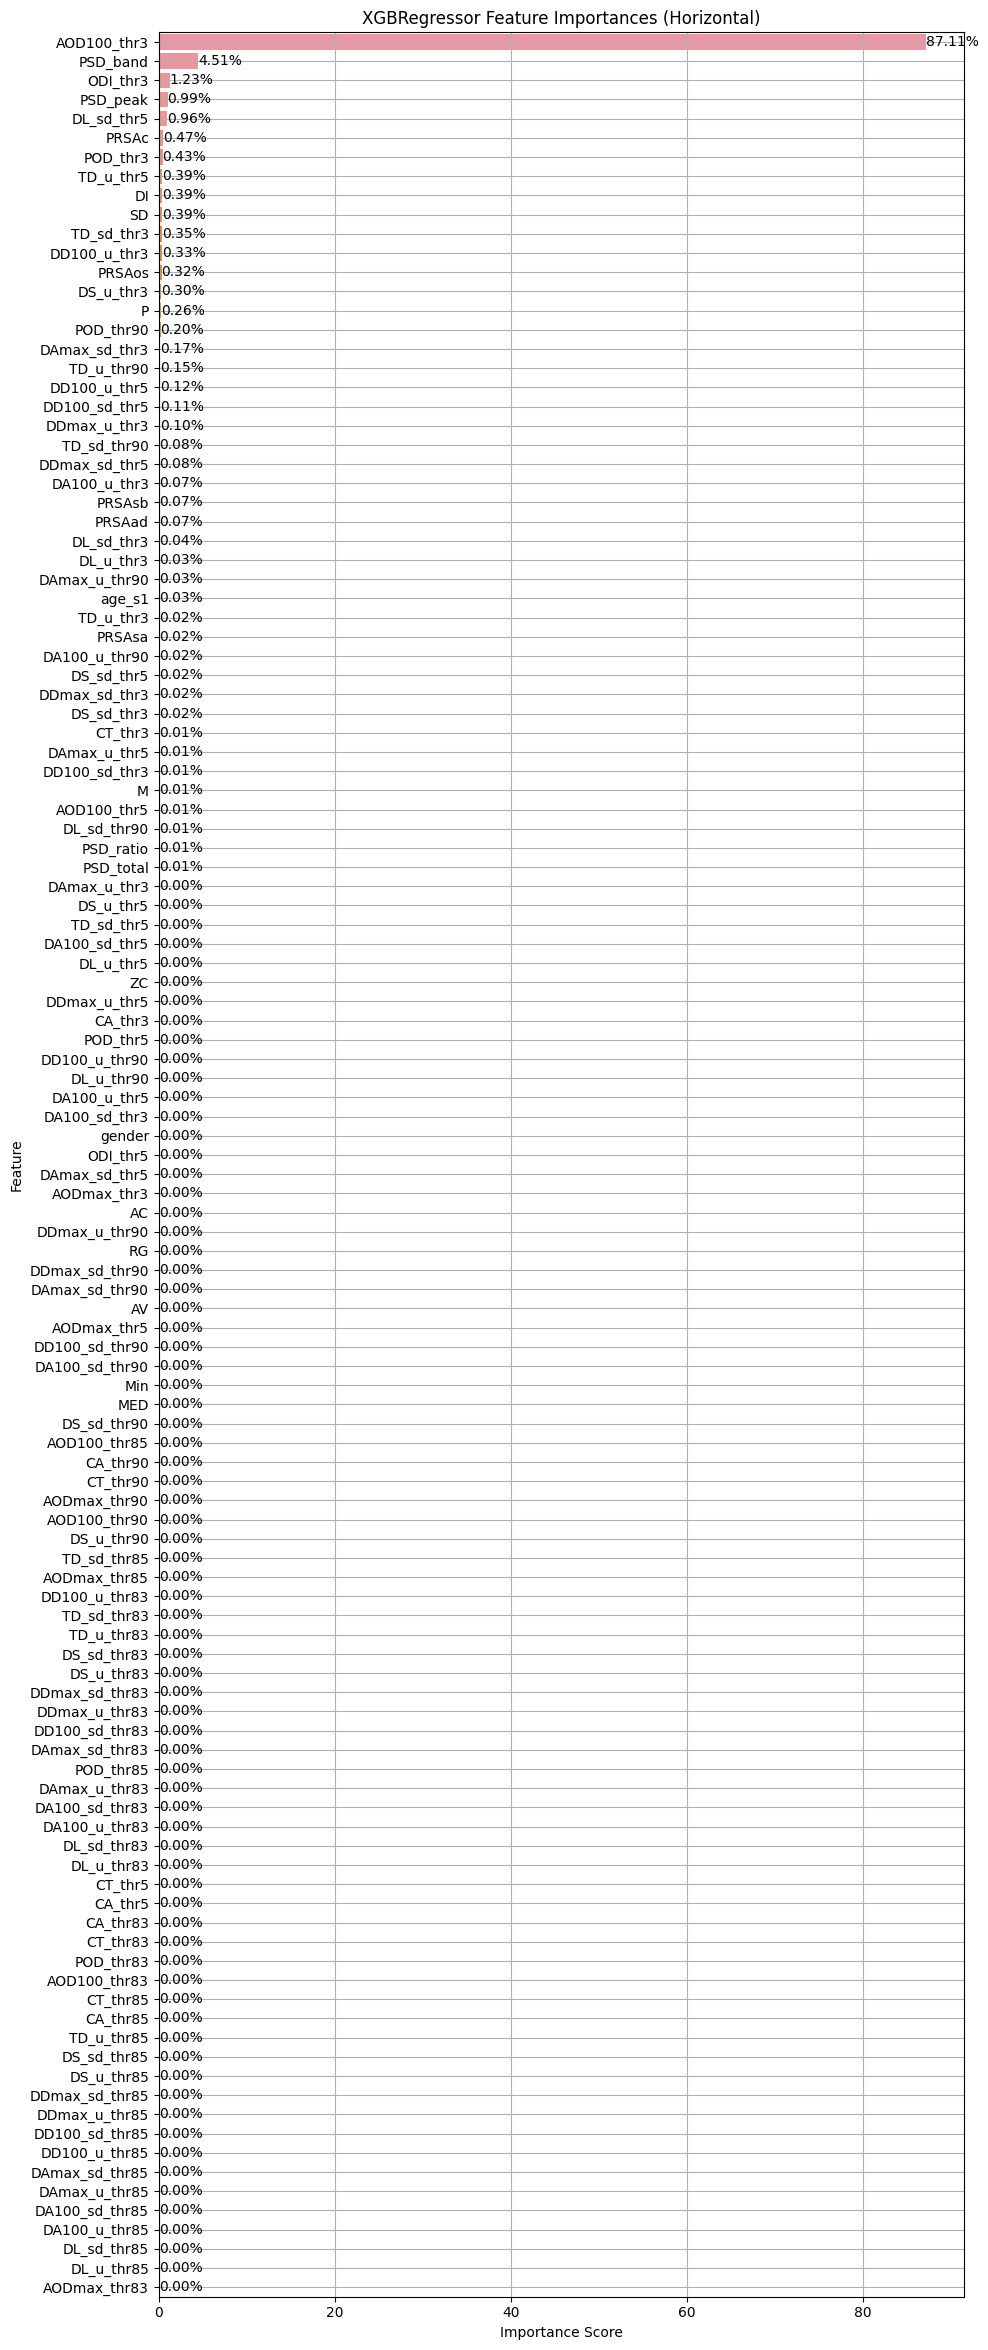

In [31]:
# Get feature importances and names
importances = xgb_model.feature_importances_
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="XGBRegressor Feature Importances")

### XGBRF Regression

In [32]:
from xgboost import XGBRFRegressor

xgbrf_model = XGBRFRegressor()
xgbrf_model.fit(X_train_scaled, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.8,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1.0, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [33]:
y_pred = xgbrf_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

45.81938926917812


In [34]:
y_pred = xgbrf_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

45.81938926917812


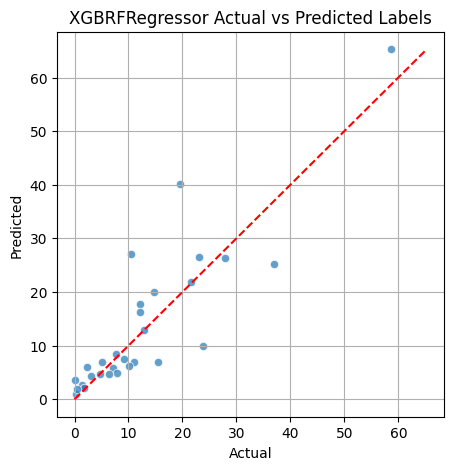

In [35]:
plot_rg(y_test, y_pred, title="XGBRFRegressor Actual vs Predicted Labels")

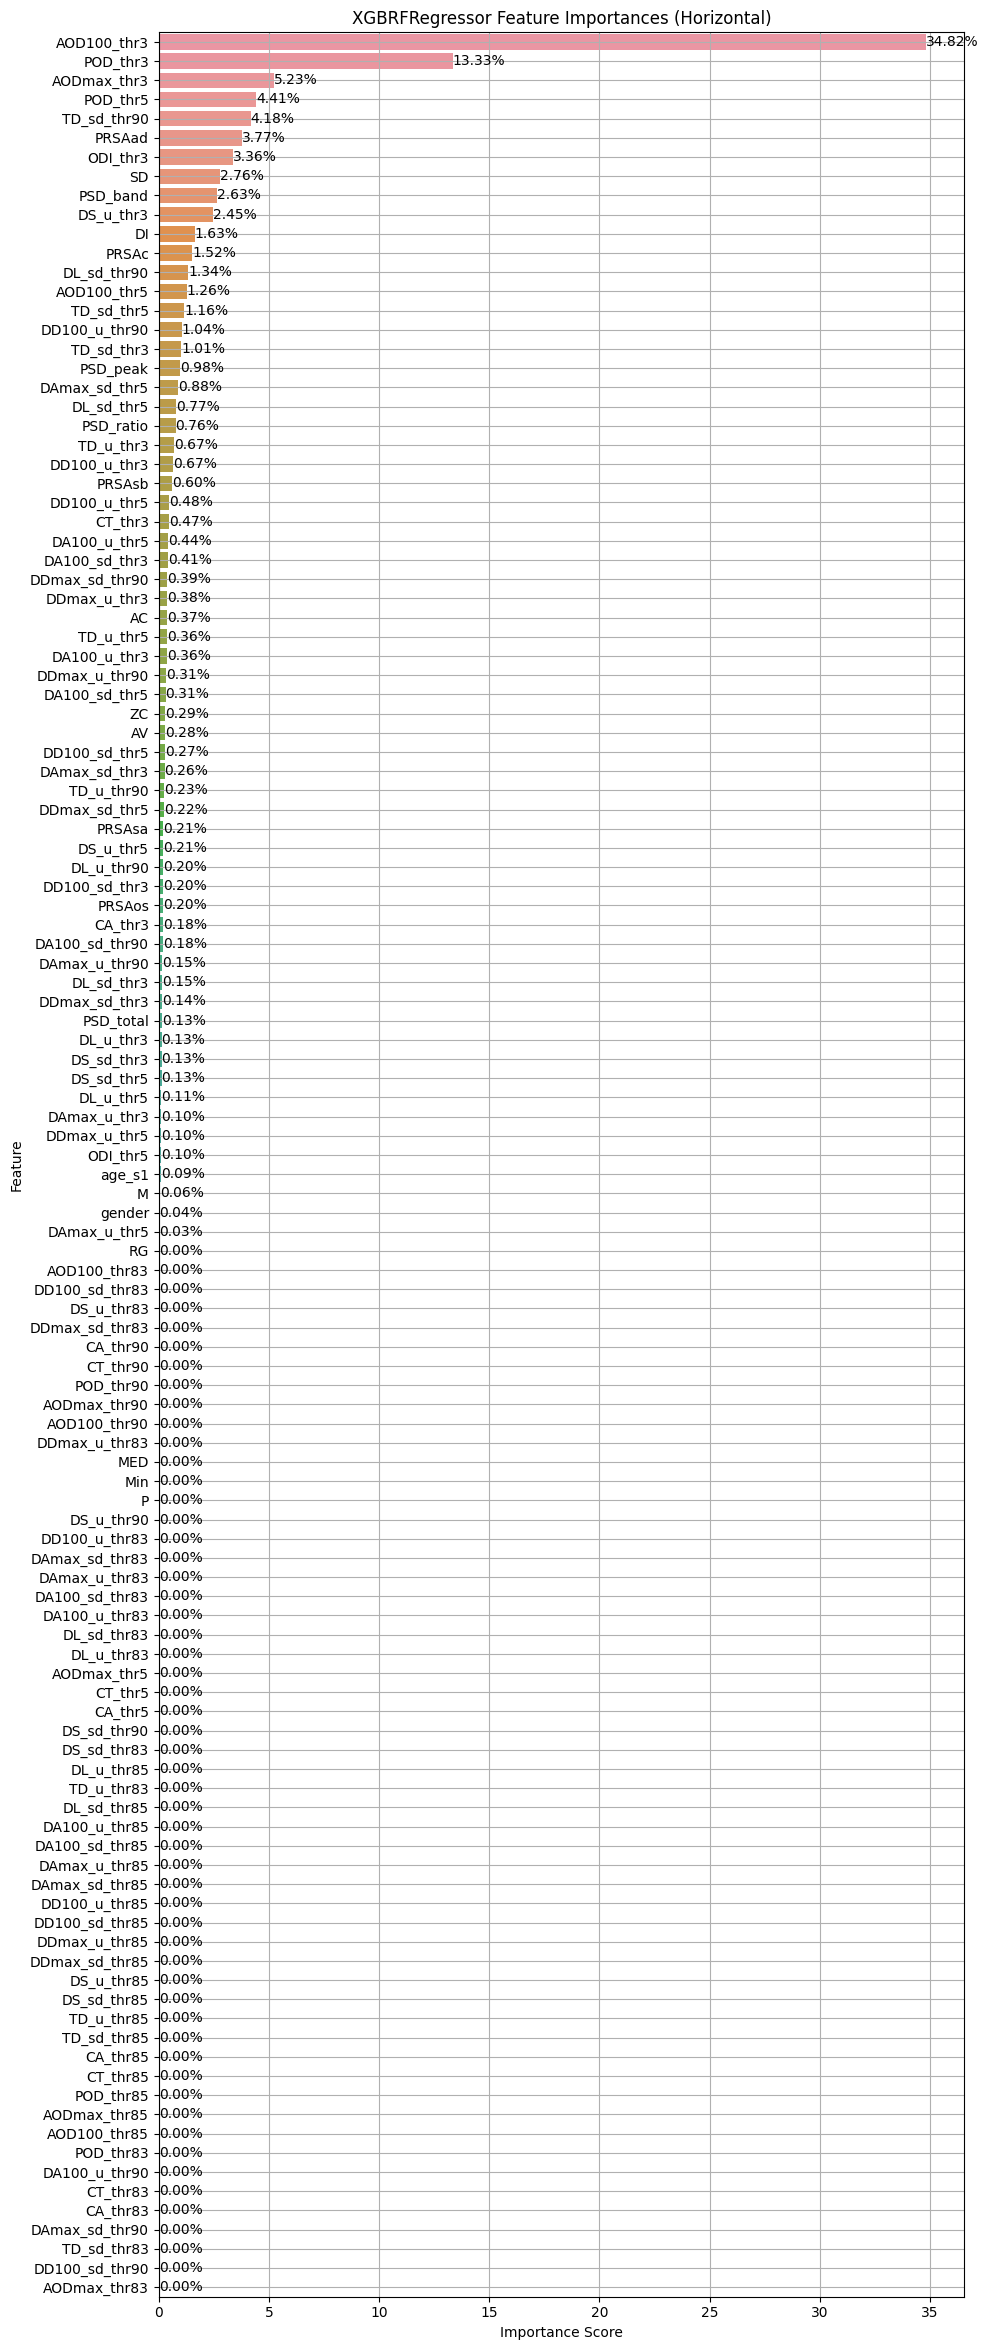

In [36]:
# Get feature importances and names
importances = xgbrf_model.feature_importances_
feature_names = X_train.columns

plot_fi(feature_names=feature_names, importances=importances, title="XGBRFRegressor Feature Importances")